# 🎙️ PrecisionVoice Evaluation (Full Settings)

Notebook này thực hiện đánh giá hiệu năng của 2 model Whisper trên 2 bộ dữ liệu tiếng Việt (`VLSP 2020` và `FPT FOSD`) sử dụng các tham số tối ưu (Full Settings) tương tự như trong giao diện của `precision_voice_simple.ipynb`.

### Cấu hình đánh giá:
- **Models**: `EraX-WoW-Turbo` & `PhoWhisper-large`.
- **Tham số**: Beam size = 5, VAD Filter = ON, Temperature = 0.0, ...
- **Dữ liệu**: VLSP 2020 VinAI (100 mẫu) & FPT FOSD (100 mẫu).
- **Metric**: WER (Word Error Rate), CER (Character Error Rate), Real-time Factor (RTF).

In [1]:
# @title 1. 🔍 Kiểm tra GPU
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Detected: {gpu_name}")
    print(f"   VRAM: {gpu_mem:.1f} GB")
else:
    print("⚠️ KHÔNG TÌM THẤY GPU!")
    print("👉 Vào Runtime → Change runtime type → T4 GPU")

✅ GPU Detected: Tesla T4
   VRAM: 15.8 GB


In [2]:
# @title 2. 📦 Cài đặt Dependencies
print("Installing dependencies...")
!pip install --upgrade torch torchvision torchaudio faster-whisper jiwer librosa datasets matplotlib pandas torchmetrics torchcodec
!apt-get install -y -qq ffmpeg > /dev/null 2>&1
print("✅ Dependencies installed successfully!")

Installing dependencies...
✅ Dependencies installed successfully!


In [3]:
# @title 3. 🛠️ Tiền xử lý văn bản & Metrics
import re
import unicodedata
from jiwer import wer, cer
from torchmetrics.text import WordErrorRate, CharErrorRate
import torch

def normalize_text(text):
    """Chuẩn hóa văn bản tiếng Việt."""
    if not text:
        return ""
    # Unicode normalization
    text = unicodedata.normalize('NFC', text)
    # Lowercase
    text = text.lower()
    # Loại bỏ dấu câu and ký tự đặc biệt
    text = re.sub(r'[\.\!\,\?\:\;\"\(\)\-]', ' ', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

wer_metric = WordErrorRate()
cer_metric = CharErrorRate()

In [4]:
# @title 4. 🤖 Load Models
import time
from faster_whisper import WhisperModel

AVAILABLE_MODELS = {
    "EraX-WoW-Turbo": "erax-ai/EraX-WoW-Turbo-V1.1-CT2",
    "PhoWhisper-Large": "kiendt/PhoWhisper-large-ct2"
}

loaded_whisper_models = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float16" if device == "cuda" else "int8"

def load_whisper_model(model_name):
    if model_name in loaded_whisper_models:
        return loaded_whisper_models[model_name]

    print(f"📥 Loading: {model_name}...")
    start = time.time()
    model = WhisperModel(
        AVAILABLE_MODELS[model_name],
        device=device,
        compute_type=compute_type
    )
    loaded_whisper_models[model_name] = model
    print(f"   ✅ Loaded in {time.time() - start:.1f}s")
    return model

In [5]:
# @title 5. ⚙️ Cấu hình Tham số (Full Settings)

EVAL_CONFIG = {
    "language": "vi",
    "beam_size": 5,
    "vad_filter": True,
    "vad_options": {
        "min_silence_duration_ms": 1000,
        "speech_pad_ms": 400,
        "min_speech_duration_ms": 250,
        "threshold": 0.5
    },
    "temperature": 0.0,
    "best_of": 5,
    "patience": 1.0,
    "length_penalty": 1.0,
    "condition_on_previous_text": True,
    "no_speech_threshold": 0.6,
    "log_prob_threshold": -1.0,
    "compression_ratio_threshold": 2.4
}

def transcribe_full(model, audio_array):
    """Thực hiện transcription với đầy đủ tham số config."""
    segments_gen, info = model.transcribe(
        audio_array,
        language=EVAL_CONFIG["language"],
        beam_size=EVAL_CONFIG["beam_size"],
        vad_filter=EVAL_CONFIG["vad_filter"],
        vad_parameters=EVAL_CONFIG["vad_options"],
        temperature=EVAL_CONFIG["temperature"],
        best_of=EVAL_CONFIG["best_of"],
        patience=EVAL_CONFIG["patience"],
        length_penalty=EVAL_CONFIG["length_penalty"],
        condition_on_previous_text=EVAL_CONFIG["condition_on_previous_text"],
        no_speech_threshold=EVAL_CONFIG["no_speech_threshold"],
        log_prob_threshold=EVAL_CONFIG["log_prob_threshold"],
        compression_ratio_threshold=EVAL_CONFIG["compression_ratio_threshold"]
    )

    text = " ".join([s.text for s in segments_gen]).strip()
    return text

In [6]:
# @title 6. 📂 Load Datasets (VLSP 2020 & FPT FOSD)
from datasets import load_dataset, Audio

print("⏳ Loading VLSP 2020 dataset (Streaming)...")
ds_vlsp = load_dataset("doof-ferb/vlsp2020_vinai_100h", split="train", streaming=True)
ds_vlsp = ds_vlsp.cast_column("audio", Audio(sampling_rate=16000))

print("⏳ Loading FPT FOSD dataset (Streaming)...")
ds_fosd = load_dataset("doof-ferb/fpt_fosd", split="train", streaming=True)
ds_fosd = ds_fosd.cast_column("audio", Audio(sampling_rate=16000))

⏳ Loading VLSP 2020 dataset (Streaming)...


Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

⏳ Loading FPT FOSD dataset (Streaming)...


In [7]:
# @title 7. 🧪 Định nghĩa hàm Evaluate
import pandas as pd
from tqdm.auto import tqdm

def run_evaluation(dataset, dataset_name, num_samples=100):
    print(f"\n🚀 Evaluating on {dataset_name} ({num_samples} samples)...")

    # Fetch samples
    samples = []
    for item in tqdm(dataset.take(num_samples), total=num_samples, desc=f"Fetch {dataset_name}"):
        samples.append({
            "audio": item["audio"]["array"],
            "ref": normalize_text(item.get("transcription", item.get("transcription_raw", "")))
        })

    dataset_results = []
    detailed_dataset_data = {"Reference": [s["ref"] for s in samples]}

    for model_name in AVAILABLE_MODELS.keys():
        model = load_whisper_model(model_name)
        preds = []

        start_time = time.time()
        for s in tqdm(samples, desc=f"Infer {model_name}"):
            pred_text = transcribe_full(model, s["audio"])
            preds.append(normalize_text(pred_text))

        total_time = time.time() - start_time

        detailed_dataset_data[model_name] = preds

        # Calc metrics
        wer_val = wer_metric(preds, detailed_dataset_data["Reference"]).item()
        cer_val = cer_metric(preds, detailed_dataset_data["Reference"]).item()

        dataset_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "WER": wer_val,
            "CER": cer_val,
            "Time (s)": total_time,
            "Avg Time/Sample": total_time / num_samples
        })

    return pd.DataFrame(dataset_results), pd.DataFrame(detailed_dataset_data)

In [8]:
# @title 8. 📊 Chạy Evaluation & Hiển thị kết quả

NUM_TEST = 500 # Số mẫu thử nghiệm cho mỗi bộ

df_vlsp_res, df_vlsp_detail = run_evaluation(ds_vlsp, "VLSP 2020", NUM_TEST)
df_fosd_res, df_fosd_detail = run_evaluation(ds_fosd, "FPT FOSD", NUM_TEST)

# Gộp kết quả tổng quan
df_final_res = pd.concat([df_vlsp_res, df_fosd_res], ignore_index=True)
display(df_final_res.style.highlight_min(subset=["WER", "CER"], color='lightgreen'))


🚀 Evaluating on VLSP 2020 (500 samples)...


Fetch VLSP 2020:   0%|          | 0/500 [00:00<?, ?it/s]

📥 Loading: EraX-WoW-Turbo...


vocabulary.json: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

   ✅ Loaded in 11.1s


Infer EraX-WoW-Turbo:   0%|          | 0/500 [00:00<?, ?it/s]

📥 Loading: PhoWhisper-Large...


config.json: 0.00B [00:00, ?B/s]

vocabulary.json: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

   ✅ Loaded in 43.9s


Infer PhoWhisper-Large:   0%|          | 0/500 [00:00<?, ?it/s]


🚀 Evaluating on FPT FOSD (500 samples)...


Fetch FPT FOSD:   0%|          | 0/500 [00:00<?, ?it/s]

Infer EraX-WoW-Turbo:   0%|          | 0/500 [00:00<?, ?it/s]

Infer PhoWhisper-Large:   0%|          | 0/500 [00:00<?, ?it/s]

,Dataset,Model,WER,CER,Time (s),Avg Time/Sample
0,VLSP 2020,EraX-WoW-Turbo,0.079138,0.067070,270.579511,0.541159
1,VLSP 2020,PhoWhisper-Large,0.060825,0.034161,823.578807,1.647158
2,FPT FOSD,EraX-WoW-Turbo,0.210423,0.156168,189.861559,0.379723
3,FPT FOSD,PhoWhisper-Large,0.032840,0.021796,377.806375,0.755613


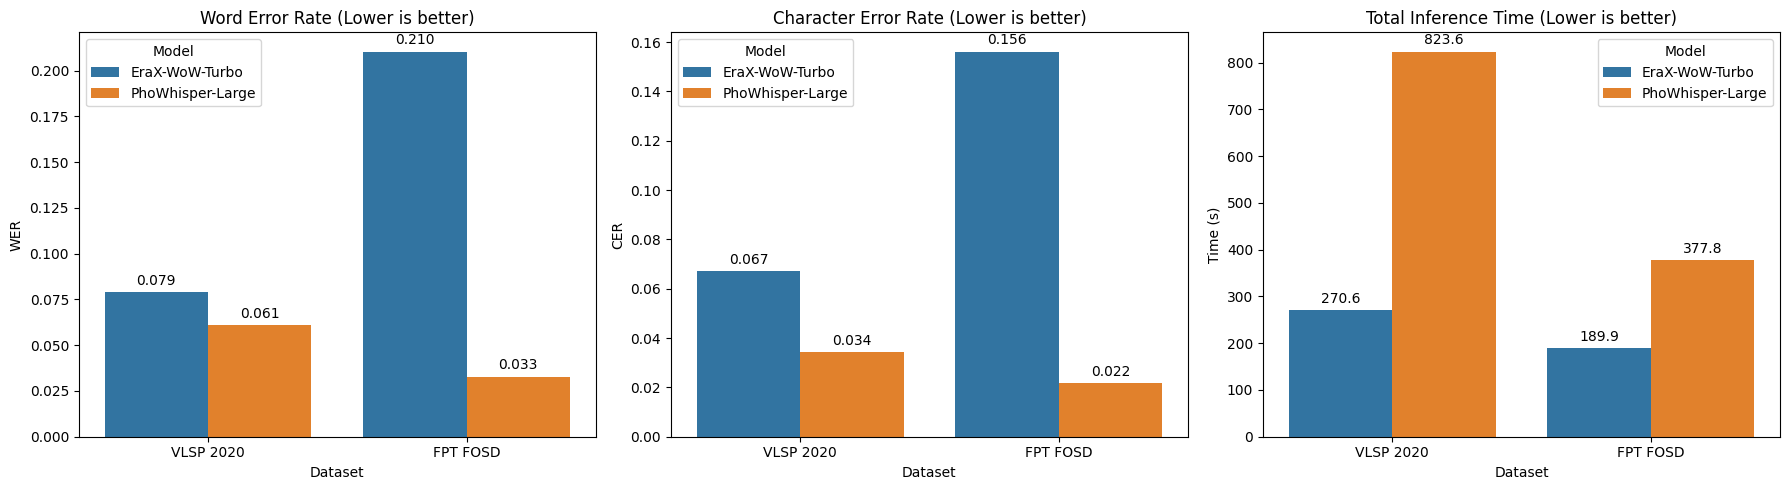

In [21]:
# @title 9. 📈 Trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    metrics = [('WER', "Word Error Rate"), ('CER', "Character Error Rate"), ('Time (s)', "Total Inference Time")]

    for i, (col, title) in enumerate(metrics):
        ax = axes[i]
        barplot = sns.barplot(data=df, x='Dataset', y=col, hue='Model', ax=ax)
        ax.set_title(f"{title} (Lower is better)")

        # Add labels on top of bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f' if 'Time' not in col else '%.1f', padding=3)

    plt.tight_layout()
    plt.show()

plot_comparison(df_final_res)

In [22]:
# @title 10. 📝 So sánh chi tiết Predicted vs Reference
from IPython.display import display

def style_detailed_df(df, title):
    print(f"\n📝 {title}:")
    # Wrap text and add styling for better readability
    styler = df.head(20).style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'max-width': '450px',
        'font-family': 'JetBrains Mono, monospace',
        'font-size': '13px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#e9ecef'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #dee2e6'), ('padding', '10px')]}
    ]).hide(axis='index')
    display(styler)

style_detailed_df(df_vlsp_detail, "VLSP 2020: 20 Samples Comparison")
style_detailed_df(df_fosd_detail, "FPT FOSD: 20 Samples Comparison")


📝 VLSP 2020: 20 Samples Comparison:


Reference,EraX-WoW-Turbo,PhoWhisper-Large
hôn thê hôn phu có nghĩa là chưa có cái giấy hôn thú nếu mà vậy thì kết cục bảo lãnh phải làm coi như là cái người mà được bảo lãnh hoặc phải ở nước ngoài con cái họ không,hôn thê hôn phu có nghĩa là chưa có cái giấy hôn thú nếu mà vậy thì kết cục bảo lãnh phải làm coi như là cái người mà được bảo lãnh hoặc phải ở nước ngoài con cái họ không,hôn thê hôn phu có nghĩa là chưa có cái giấy hôn thú nếu mà vậy thì kết cục bảo lãnh phải làm coi như là cái người mà được bảo lãnh hoặc phải ở nước ngoài
theo bà đây là một sự thật đã được thừa nhận rộng rãi,hợp theo bà đây là một sự thật đã được thừa nhận rộng rãi,theo bà đây là một sự thật đã được thừa nhận rộng rãi
tướng cam pu chia còn yêu cầu thủ tướng sinh ga po phải điều chỉnh phát biểu không đúng sự thật chút nào này theo lời ông,tướng cam pu chia còn yêu cầu thủ tướng sinh ga po phải điều chỉnh phát biểu không đúng sự thật chút nào này theo lời ông,tướng cam pu chia còn yêu cầu thủ tướng singapore phải điều chỉnh phát biểu không đúng sự thật chút nào này theo lời ông
nó làm người dân mặc dù nhìn thì rất bình thường nhưng mà rất rất là rộn ràng từ từ trên các đường phố và trên mỗi con mỗi con người,ở nó làm người dân mặc dù nhìn thì rất là bình thường nhưng mà rất rất là rộn ràng từ từ trên các đường phố và trên mỗi con mỗi con người,nó làm người dân mặc dù nhìn thì rất bình thường nhưng mà rất rất rộn ràng từ từ trên các đường phố và trên mỗi con mỗi con người
bây giờ mình nói từ thẻ xanh hai năm tới thẻ xanh vĩnh viễn minh đang ờ nói về thẻ xanh nhưng mà có quá nhiều câu hỏi,bây giờ mình nói từ thẻ xanh hai năm tới thẻ xanh vĩnh viễn mình đang nói về thẻ xanh nhưng mà có quá nhiều câu hỏi,bây giờ mình nói từ thẻ xanh hai năm tới thẻ xanh vĩnh viễn mình đang nói về thẻ xanh nhưng mà có quá nhiều câu hỏi
mọi người đã thử các kiểu ăn kiêng và luyện tập khác nhau mà không hiệu quả họ thấy nếch kịt như một cách để thấy được sự rõ ràng hơn về những gì đang thay đổi trên cơ thể của họ,mọi người đã thử các kiểu ăn kiêng và luyện tập khác nhau mà không hiệu quả họ thấy nếch kịt như một cách để thấy được sự rõ ràng hơn về những gì đang thay đổi trên cơ thể của họ,mọi người đã thử các kiểu ăn kiêng và luyện tập khác nhau mà không hiệu quả họ thấy nếch kịt như một cách để thấy được sự rõ ràng hơn về những gì đang thay đổi trên cơ thể của họ
khi chúng tôi về đến đó thì thấy gần tối rồi chúng tôi nghĩ rằng là cần phải có sự an toàn đối với người dân là trên hết hai nữa thì chúng tôi cũng nhận được sự góp ý của anh em linh mục và của bề trên thì chúng tôi quyết định để cho bà con ra về ạ,sách khi chúng tôi về đến đó thì thấy gần tối rồi chúng tôi nghĩ rằng là cần phải có sự an toàn đối với người dân là trên hết hai nữa thì chúng tôi cũng nhận được sự góp ý của anh em linh mục và của bề trên thì chúng tôi hình để cho bà con ra về ạ,khi chúng tôi về đến đó thì thấy yếu đắm tối rồi chúng tôi nghĩ rằng là cần phải có sự an toàn đối với người dân và trên hết hai nữa thì chúng tôi cũng nhận được sự góp ý của anh em linh mục và của bề trên vì chúng tôi định để cho bà con ra về ạ
bà cho biết cuộc đua của bà đang diễn ra gay go vì số phiếu khiếm diện gửi lại không nhiều như trông đợi và bà đang nỗ lực hết sức để huy động nhiều phiếu của cử tri gốc việt nhất có thể,bà cho biết cuộc đua của bà đang diễn ra gay go vì số phiếu khiếm diện gửi lại không nhiều như trông đợi và bà đang nỗ lực hết sức để huy động nhiều phiếu của cử tri gốc việt nhất có thể,bà cho biết cuộc đua của bà đang diễn ra gay go vì số phiếu khiếm diện gửi lại không nhiều như trông đợi và bà đang nỗ lực hết sức để huy động nhiều phiếu của cử tri gốc việt nhất có thể
nếu nấu cơm đảm bảo thì mình cứ lấy gạo nó ngon ngon một chút thì về mình nấu cơm nó ngon nên thì người ta mua thì một lần hai lần ta thấy ngon thì người ta cứ tới người ta mua hoài vậy đó,nấu cơm đảm bảo thì mình cứ lấy gạo nó ngon ngon một chút thì về mình nấu cơm nó ngon nên thì người ta mua thì một lần hai lần ta thấy ngon thì ngư


📝 FPT FOSD: 20 Samples Comparison:


Reference,EraX-WoW-Turbo,PhoWhisper-Large
cách để đi,cho cách để đi,cách để đi
họ đã xét nghiệm máu cho cheng nhưng mọi thứ vẫn hoàn toàn bình thường,mọi thứ vẫn hoàn toàn bình thường,họ đã xét nghiền máu cho trang nhưng mọi thứ vẫn hoàn toàn bình thường
anh có thể gọi tôi không,cho anh có thể gọi tôi không,anh có thể gọi tôi không
có rất nhiều yếu tố may rủi ở đây,yếu tố may rủi ở đây,có rất nhiều yếu tố may rủi ở đây
ai là chúa nói dối,ai là thừa nơi dối,ai là chúa nói dối
có cửa hàng tiện lợi ở sân bay không,hồn qua cửa hàng tiện lợi ở sân bay không,có cửa hàng tiện lợi ở sân bay không
anh đổi ngoại tệ được không,anh đổi ngoại tệ được không,anh đổi ngoại tệ được không
cô ấy mua hai mươi trái chôm chôm và ba con cá,tuy mua 20 trải chôm chôm và 3 con cá,cô ấy mua hai mươi trái chôm chôm và ba con cá
đứa bé có ói òng ọc ra sữa hoặc nước và bé chưa đến mười tuần tuổi hoặc có biểu hiện mất nước không,và đưa bé có ối ông học ra sữa hoặc nước và bé chưa đến mười tuần tuổi hoặc có biểu hiện mất nữa không,đứa bé có ói òng ọc ra sữa hoặc nước và bé chưa đến mười tuần tuổi hoặc có biểu hiện mất nước không
tôi có thể viết tên địa chỉ số điện thoại của công ty bảo hiểm của anh được không,tại tôi có thể viết tên địa chỉ số điện thoại của công ty bảo hiểm của anh được không,tôi có thể viết tên địa chỉ số điện thoại của công ty bảo hiểm của anh được không
